In [1]:
# import necessary modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# listing files
files = os.listdir("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data")
print(files)
# training data
path = 'C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data/'
app_train = pd.read_csv(path + files[1])
print('training dataset shape:', app_train.shape)
#print(app_train.columns)
app_test = pd.read_csv(path + files[0])
print('test dataset shape:', app_test.shape)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
training dataset shape: (307511, 122)
test dataset shape: (48744, 121)


In [3]:
bureau = pd.read_csv(path + files[2])
bureau_bal = pd.read_csv(path + files[3])
credit_bal = pd.read_csv(path + files[4])
inst_pay = pd.read_csv(path + files[6])
cash_bal = pd.read_csv(path + files[7])
prev_app = pd.read_csv(path + files[8])

In [4]:
print('bureau shape:', bureau.shape)
print('bureau_bal shape:', bureau_bal.shape)
print('credit_bal shape:', credit_bal.shape)
print('inst_pay shape:', inst_pay.shape) 
print('cash_bal shape:', cash_bal.shape)
print('prev_app shape:', prev_app.shape)

bureau shape: (1716428, 17)
bureau_bal shape: (27299925, 3)
credit_bal shape: (3840312, 23)
inst_pay shape: (13605401, 8)
cash_bal shape: (10001358, 8)
prev_app shape: (1670214, 37)


In [5]:
target_val = app_train['TARGET'].value_counts()
print(target_val)
print('% repaid loan: {:05.2f}'.format(target_val[0]/(target_val[0] + target_val[1])*100)) 
print('% difficulty in loan repayment: {:04.2f}'.format(target_val[1]/(target_val[0] + target_val[1])*100))


0    282686
1     24825
Name: TARGET, dtype: int64
% repaid loan: 91.93
% difficulty in loan repayment: 8.07


Discussion: Among 307511 applicants, 282686 (92%) repaid the loan on time. 24825 (8%) had difficulties in repaying. 

## Missing values in the given datasets

In [6]:
## Missing values in appication_train
print('Total number of variables:', app_train.shape[1])
miss_val = app_train.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', app_train.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(app_train) * 100 # percent missing value for each variable
percents =[10 , 30, 50]
for percent in percents:
    for i in range(len(percent_miss)):
        if percent_miss.sort_values()[i] > percent:
            print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
            break

Total number of variables: 122
Out of 122 , number of variables with missing values: 67
Out of 67 , there are 57 variables with more than 10 % missing values
Out of 67 , there are 50 variables with more than 30 % missing values
Out of 67 , there are 41 variables with more than 50 % missing values


Discussion
Among 122 variables 67 variables have missing values. 57 variables have more than 10% value missing, 50 variables have more than 30% values missing, and 41 variables have more than 50% values missing. So, a large number of variables missing values. How can we deal with those missing values??

In [7]:
var_names = [app_train, app_test, bureau, bureau_bal, credit_bal, inst_pay, cash_bal, prev_app]
names = ['app_train', 'app_test', 'bureau', 'bureau_bal', 'credit_bal', 'inst_pay', 'cash_bal', 'prev_app']
## Missing values in bureau
for i in range(len(var_names)):
    print('Name of the variable is:', names[i])
    print('Total number of features:', var_names[i].shape[1])
    miss_val = var_names[i].isnull().sum() # number of missing value in each col
    miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
    miss_list = list(miss_val)
    ind = miss_list.index(0)
    miss_var = miss_val[0:ind] # only variables with missing values
    print('Out of', var_names[i].shape[1], ', number of variables with missing values:', ind)

    percent_miss = miss_var/len(var_names[i]) * 100 # percent missing value for each variable
    percents =[10 , 30, 50]
    for percent in percents:
        for i in range(len(percent_miss)):
            if percent_miss.sort_values()[i] > percent:
                print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
                break
    print(percent_miss.head())
    print('----------------------------------------------------------------------------------------')

Name of the variable is: app_train
Total number of features: 122
Out of 122 , number of variables with missing values: 67
Out of 67 , there are 57 variables with more than 10 % missing values
Out of 67 , there are 50 variables with more than 30 % missing values
Out of 67 , there are 41 variables with more than 50 % missing values
COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_MEDI    69.432963
dtype: float64
----------------------------------------------------------------------------------------
Name of the variable is: app_test
Total number of features: 121
Out of 121 , number of variables with missing values: 64
Out of 64 , there are 57 variables with more than 10 % missing values
Out of 64 , there are 50 variables with more than 30 % missing values
Out of 64 , there are 29 variables with more than 50 % missing values
COMMONAREA_MEDI             68.716150
COMMO

Many variables have missing data. So, we need to come up with certain way to replace them.

In [8]:
# app_train variable type, object type are categorical variables
print('Variable types are:\n', app_train.dtypes.value_counts()) # variable type: integer, float, categorical
obj = app_train.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())
var_float = app_train.select_dtypes('float64')
print('\nVariables with float outcome:\n', var_float.columns)
var_int = app_train.select_dtypes('int64')
print('\nVariables with integer outcome:\n', var_int.columns)
var_int_uni = var_int.apply(pd.Series.nunique, axis=0)
print(var_int_uni.sort_values())

Variable types are:
 float64    65
int64      41
object     16
dtype: int64

Unique values in categorical variables are:
 NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

Variables with float outcome:
 Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       

There are 3 variable types: 65 float, 41 integer, and 16 object (categorical). Among the categorical variables 15 variables have less than 7 unique values. Among 41 integer variables 35 have 3 unique values. So it would be best to present them with count plots/ pie charts. The float type variables can be presented using distribution. 

### Distribution of variables in app_train

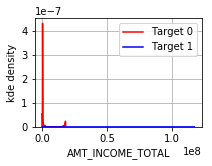

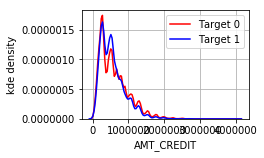

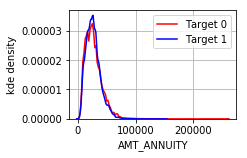

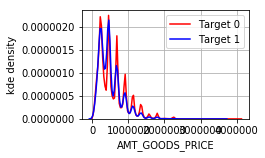

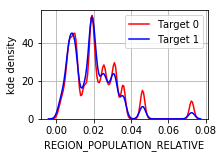

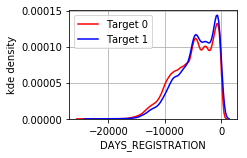

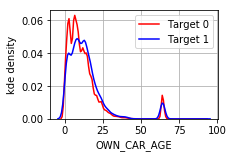

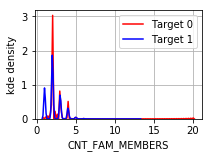

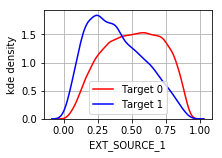

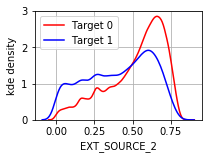

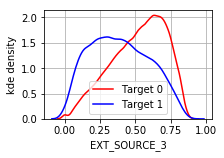

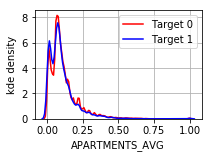

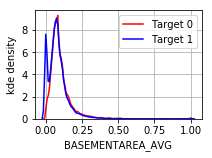

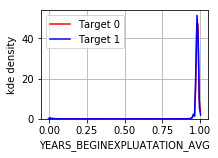

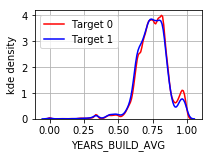

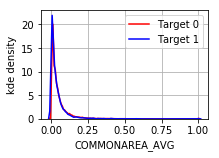

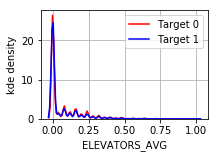

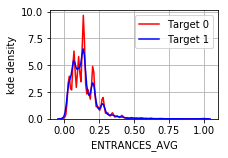

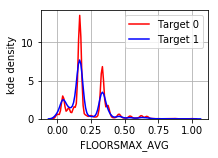

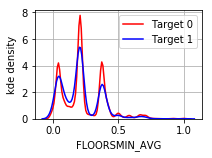

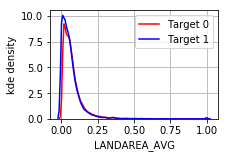

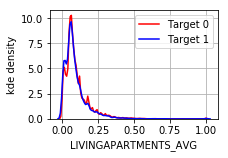

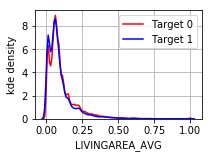

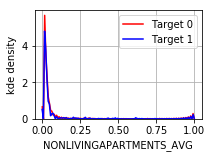

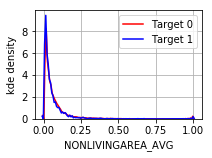

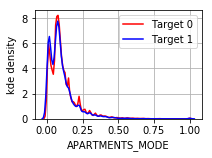

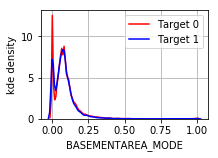

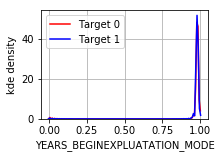

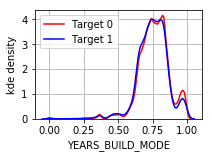

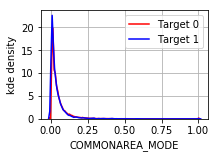

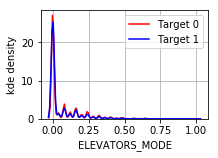

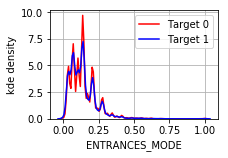

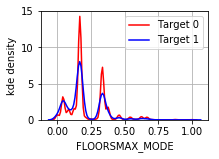

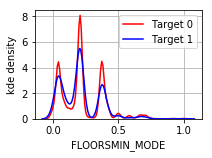

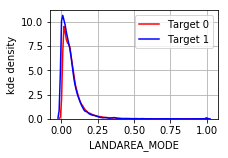

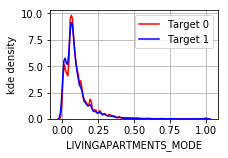

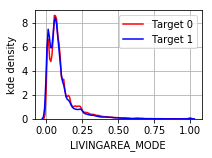

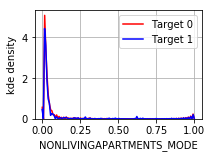

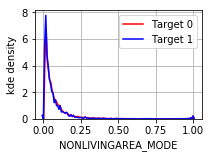

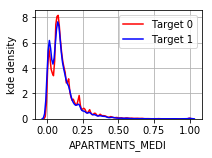

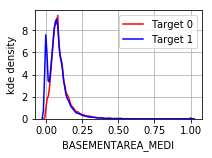

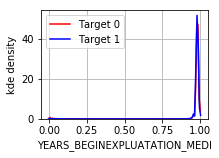

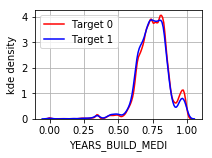

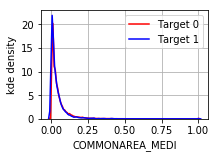

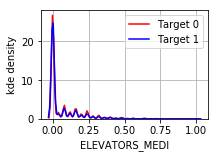

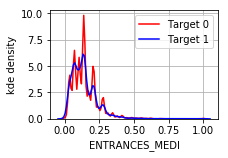

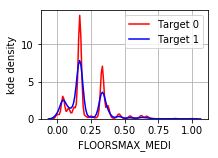

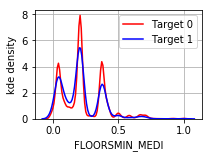

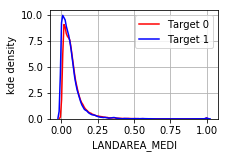

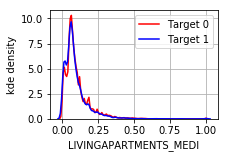

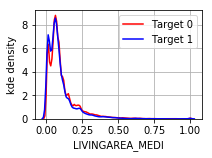

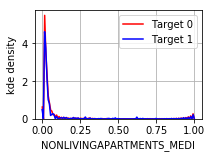

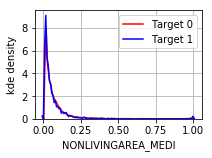

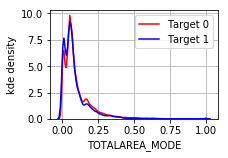

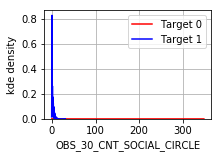

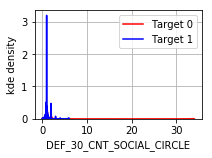

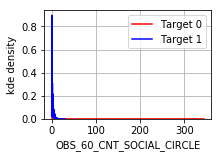

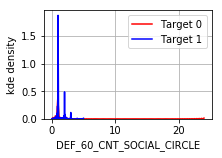

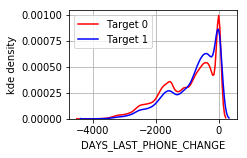

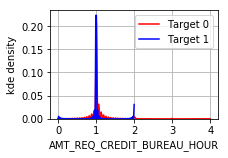

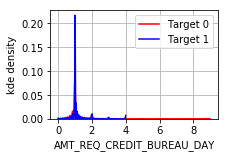

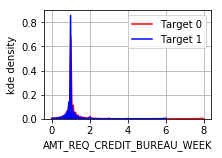

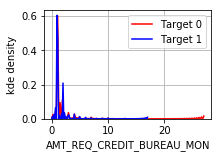

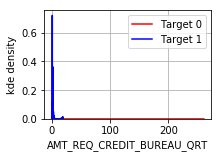

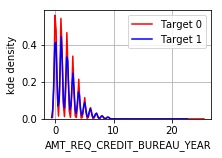

In [206]:
var_names = var_float.columns
for var in var_names:
#var = 'AMT_CREDIT'
    #sns.kdeplot(app_train[var], label = 'all', color='black')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
    plt.xlabel(var)
    plt.ylabel('kde density')
    plt.grid(True)
    plt.rcParams['figure.figsize'] = 3,2
    plt.show()


Among all these variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 seems to have differenciable distribution for target 0 and 1. So, these variables are important in predicting the target.

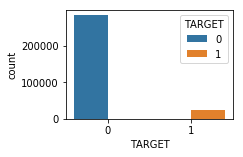

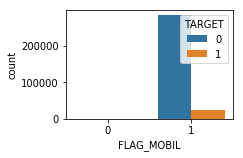

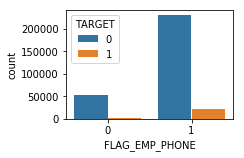

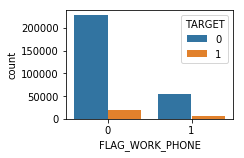

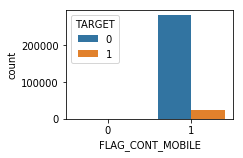

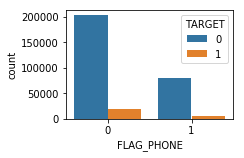

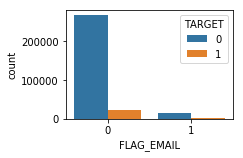

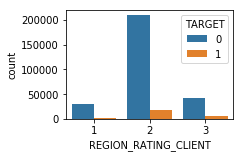

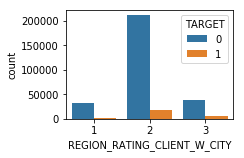

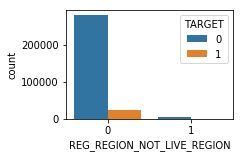

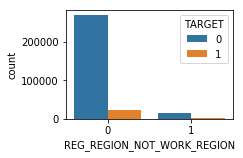

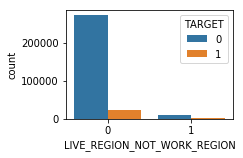

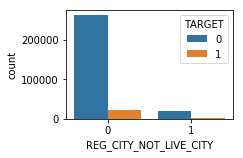

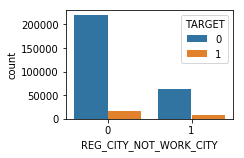

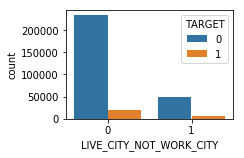

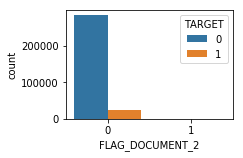

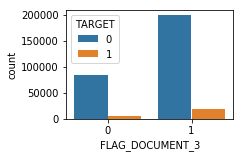

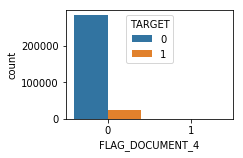

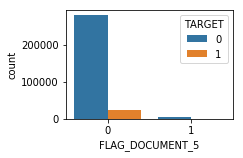

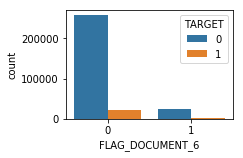

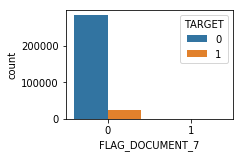

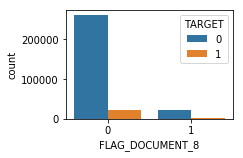

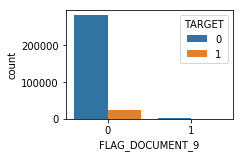

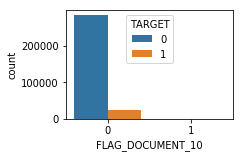

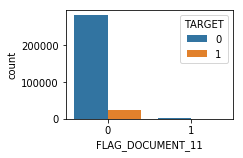

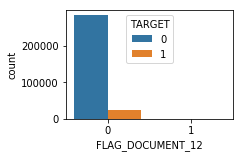

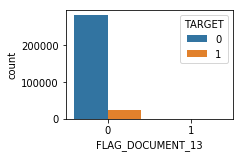

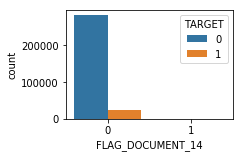

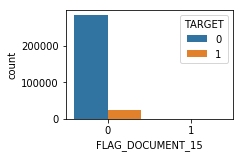

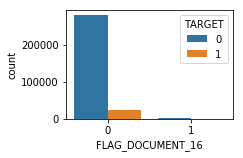

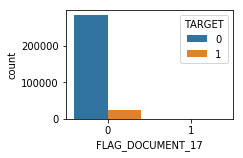

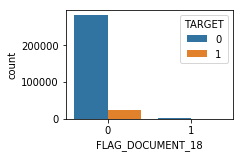

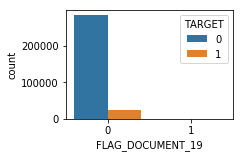

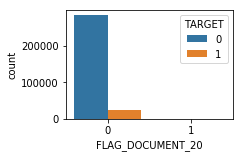

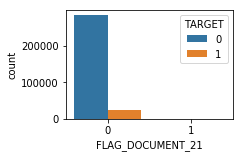

In [230]:
var_int_cnt = var_int.drop(columns = ['CNT_CHILDREN', 'HOUR_APPR_PROCESS_START', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'])
var_names = var_int_cnt.columns
for var in var_names:
    #sns.countplot()
    sns.countplot(x=var, hue="TARGET", data=var_int_cnt)
    plt.show()

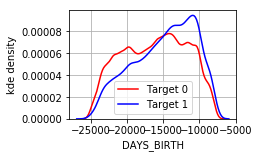

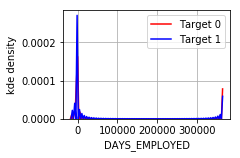

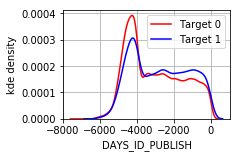

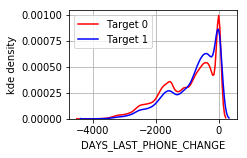

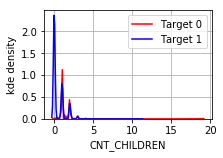

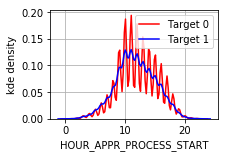

In [231]:
var_int_dist = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_ID_PUBLISH, 
                          app_train.DAYS_LAST_PHONE_CHANGE, app_train.CNT_CHILDREN, app_train.HOUR_APPR_PROCESS_START], axis=1)

var_names = var_int_dist.columns
for var in var_names:
#var = 'AMT_CREDIT'
    #sns.kdeplot(app_train[var], label = 'all', color='black')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, var], label = 'Target 0', color='red')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, var], label = 'Target 1', color='blue')
    plt.xlabel(var)
    plt.ylabel('kde density')
    plt.grid(True)
    plt.rcParams['figure.figsize'] = 3,2
    plt.show()


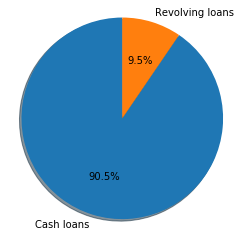

Name of variable: NAME_CONTRACT_TYPE


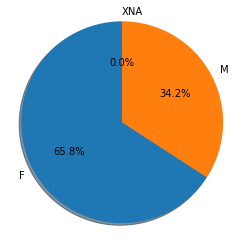

Name of variable: CODE_GENDER


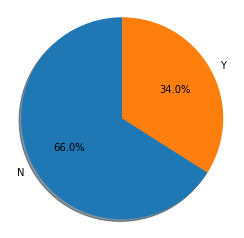

Name of variable: FLAG_OWN_CAR


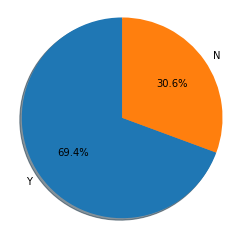

Name of variable: FLAG_OWN_REALTY


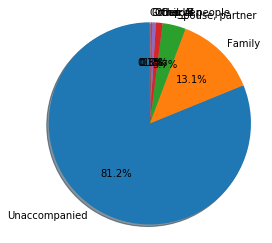

Name of variable: NAME_TYPE_SUITE


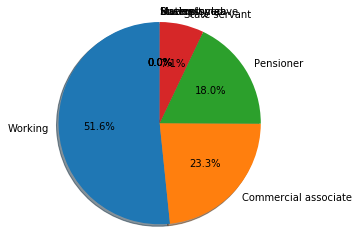

Name of variable: NAME_INCOME_TYPE


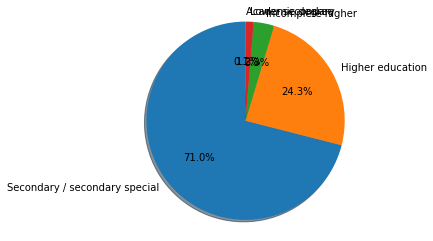

Name of variable: NAME_EDUCATION_TYPE


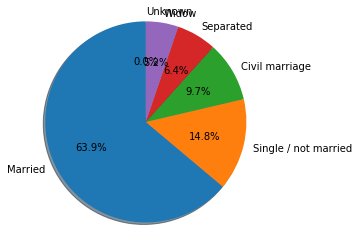

Name of variable: NAME_FAMILY_STATUS


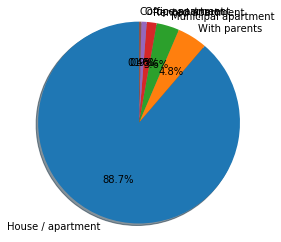

Name of variable: NAME_HOUSING_TYPE


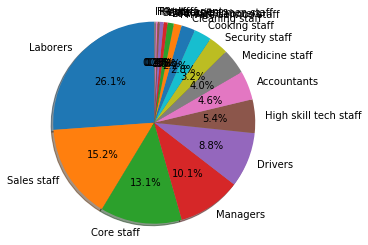

Name of variable: OCCUPATION_TYPE


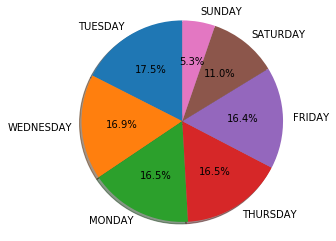

Name of variable: WEEKDAY_APPR_PROCESS_START


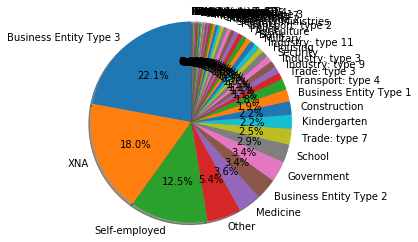

Name of variable: ORGANIZATION_TYPE


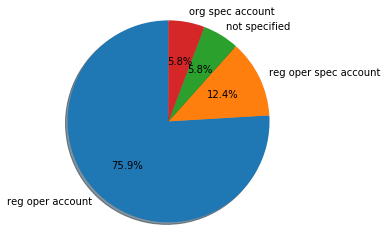

Name of variable: FONDKAPREMONT_MODE


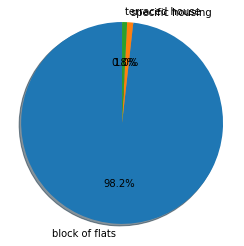

Name of variable: HOUSETYPE_MODE


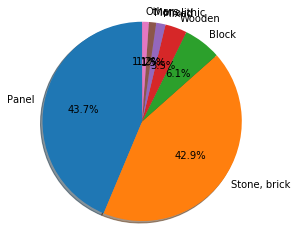

Name of variable: WALLSMATERIAL_MODE


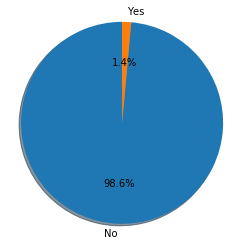

Name of variable: EMERGENCYSTATE_MODE


In [71]:
var_obj = obj.columns
for var in var_obj:
    variable = app_train[var].value_counts()
    group_names = variable.index
    group_size = variable
    #ax.pie(group_size, labels=group_names)
    fig1, ax1 = plt.subplots()
    ax1.pie(group_size, labels=group_names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #plt.legend(loc='upper right')
    plt.rcParams['figure.figsize'] = 4,4
    plt.show()
    print('Name of variable:', var)
    

## Dealing with missing values and anomalies: app_train, app_test

Label encoding and One-hot encoding
For categorical variables with unique categories = 2, we will use label encoding, and with unique categories > 2, we will use one-hot encoding. The underlying assumption is keep it the values in one column when unique values = 2. Thus the number of column is same here.

In [72]:
# # fitting and transforming with label encoder in app_train
le = LabelEncoder()
le_count = 0
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2: # for unique category less/equal 2
            le.fit(app_train[col]) # fitting and transforming with label encoder
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            le_count += 1
print(le_count)

3


In [73]:
## One hot encoding for unique category >2 in app_train
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)
print(app_train.shape, app_test.shape)

(307511, 243) (48744, 239)


In [74]:
## geting rid of excess columns in train dataset
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis=1)
app_train['TARGET'] = train_labels
print(app_train.shape, app_test.shape)

(307511, 240) (48744, 239)


From HomeCredit_columns_description.csv it is apparent that DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE columns are populated with the number of days relative to the application, thus are negative. 

In [75]:
days_columns = pd.concat([app_train.DAYS_BIRTH, app_train.DAYS_EMPLOYED, app_train.DAYS_REGISTRATION, app_train.DAYS_ID_PUBLISH, app_train.DAYS_LAST_PHONE_CHANGE], axis=1)
(days_columns/-365).describe() # summary statistics in terms of years (not days)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,-174.835742,13.660604,8.203294,2.637969
std,11.956133,387.056895,9.651743,4.135481,2.265229
min,20.517808,-1000.665753,-0.000000,-0.000000,-0.000000
25%,34.008219,0.791781,5.506849,4.712329,0.750685
50%,43.150685,3.323288,12.339726,8.915068,2.073973
75%,53.923288,7.561644,20.491781,11.778082,4.301370
max,69.120548,49.073973,67.594521,19.717808,11.758904


The average age of applicant ~ 44 years, youngest ~ 21 year, oldest ~ 69 year .. sounds about right.
In employment history the minimum and mean value are -1000 years and -174 years.. not right. But registration, id publish time and last phone change looks about right. 

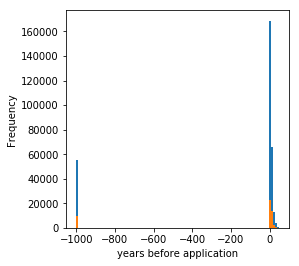

% anomaly in train.DAYS_EMPLOYED: 18.01
% anomaly in test.DAYS_EMPLOYED: 19.03


In [76]:
# distribution of 'DAYS_EMPLOYED' data
(app_train['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
(app_test['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
plt.xlabel('years before application')
plt.show()

print('% anomaly in train.DAYS_EMPLOYED: {:05.2f}'.format(len(app_train[app_train['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(app_train['DAYS_EMPLOYED'])*100))
print('% anomaly in test.DAYS_EMPLOYED: {:05.2f}'.format(len(app_test[app_test['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(app_test['DAYS_EMPLOYED'])*100))


A large spike can be seen at 1000 caused by anomalies. There anomaly in train and test data are ~ 18% and 19% respectively of total 'DAYS_EMPLOYED.

### Correlation with target

In [77]:
# find correlation of the features with target
correlations =  app_train.corr()['TARGET'].sort_values()
print('Most negative correlations:\n', correlations.head(10), '\n\nMost positive correlations\n', correlations.tail(10))

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64 

Most positive correlations
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                              

The correlation of any individual variable with the target is not strong. DAYS_BIRTH has strongest positive relation and EXIT_SOURCE_3 has maximum negative correlation. However, if we apply feature engineering the correlation canbe improved.

## Feature Engineering

In [78]:
# Feature engineering by combining several features to have higher correlation with the target
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET']) # seperating TARGET column from train dataset

#replacing missing values (external sources have missing values)
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

# create polynomial object
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 3)

# train the polynomial features
poly_transformer.fit(poly_features)

# transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print(poly_features.shape) # we started with 4 variables as poly features and ended with 35
columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
print(columns[:10]) # new feature names

(307511, 35)
['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_2^2']


We started with 4 features and after transformation we have 35 features which are all possible combination between polynomial features, such as EXT_SOURCE_1^2, EXT_SOURCE_1 EXT_SOURCE_2, EXT_SOURCE_1 EXT_SOURCE_3 etc.

In [79]:
# checking correlation with target
# creating dataframe with new features in train dataset
poly_features = pd.DataFrame(poly_features, columns = columns)
poly_features['TARGET'] = poly_target

# find correlation in train
poly_corrs = poly_features.corr()['TARGET'].sort_values()
print(poly_corrs.head(10), '\n', poly_corrs.tail(10))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64 
 EXT_SOURCE_1 DAYS_BIRTH                 0.104882
EXT_SOURCE_3^2 DAYS_BIRTH               0.141777
EXT_SOURCE_2^2 DAYS_BIRTH               0.149313
EXT_SOURCE_3 DAYS_BIRTH                 0.150109
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH    0.151816
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                 

The correlations have improved than earlier. There are several features which are important to understand the financial capacity of a cliet, such as the percentage of the credit amount relative to a client's income (CREDIT_INCOME_PERCENT), the percentage of the loan annuity relative to a client's income (ANNUITY_INCOME_PERCENT), the length of the payment in months (since the annuity is the monthly amount due (CREDIT_TERM), the percentage of the days employed relative to the client's age (DAYS_EMPLOYED_PERCENT) etc. 

In [85]:
app_train_domain = app_train.copy()
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
domain = pd.concat([app_train_domain['CREDIT_INCOME_PERCENT'], app_train_domain['ANNUITY_INCOME_PERCENT'], app_train_domain['CREDIT_TERM'], app_train_domain['DAYS_EMPLOYED_PERCENT'], app_train_domain['TARGET']], axis=1)
app_test_domain = app_test.copy()
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
domain_corrs = domain.corr()['TARGET'].sort_values()
print(domain_corrs)

CREDIT_INCOME_PERCENT    -0.007727
CREDIT_TERM               0.012704
ANNUITY_INCOME_PERCENT    0.014265
DAYS_EMPLOYED_PERCENT     0.042206
TARGET                    1.000000
Name: TARGET, dtype: float64


The correlation is not good with engineered features. 

What about other datasets!! Can we include them in train and test dataset and improve the prediction!!

In [88]:
print('bureau', bureau.columns)
print('bureau_bal', bureau_bal.columns)
print('credit balance', credit_bal.columns)
print('installment payment', inst_pay.columns)
print('cash balance', cash_bal.columns)
print('previous application', prev_app.columns)


bureau Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')
bureau_bal Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS'], dtype='object')
credit balance Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWING

In [96]:
print('Bureau variable types are:\n', bureau.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nbureau balance variable types are:\n', bureau_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nCredit balance variable types are:\n', credit_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nInstallment payment variable types are:\n', inst_pay.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nCash balance variable types are:\n', cash_bal.dtypes.value_counts()) # variable type: integer, float, categorical
print('\nPrevious application variable types are:\n', prev_app.dtypes.value_counts()) # variable type: integer, float, categorical


Bureau variable types are:
 float64    8
int64      6
object     3
dtype: int64

bureau balance variable types are:
 int64     2
object    1
dtype: int64

Credit balance variable types are:
 float64    15
int64       7
object      1
dtype: int64

Installment payment variable types are:
 float64    5
int64      3
dtype: int64

Cash balance variable types are:
 int64      5
float64    2
object     1
dtype: int64

Previous application variable types are:
 object     16
float64    15
int64       6
dtype: int64


In [116]:
bureau_train = pd.merge(app_train, bureau, on='SK_ID_CURR', how='left')
bureau_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


There are multiple entry for one SKIDCURR in bureau. So the number of rows increased.

In [119]:
app_train.shape

(307511, 240)

In [118]:
credit_bal_train = pd.merge(app_train, credit_bal, on='SK_ID_CURR', how='left')
credit_bal_train.shape

(3448571, 262)

In [120]:
inst_pay_train = pd.merge(app_train, inst_pay, on='SK_ID_CURR', how='left')
inst_pay_train.shape

(11607460, 247)

In [121]:
cash_bal_train = pd.merge(app_train, cash_bal, on='SK_ID_CURR', how='left')
cash_bal_train.shape

(8561442, 247)